In [1]:
import datetime
import random
import os
import logging
import requests

In [2]:
import numpy as np
import pandas as pd
import h5py as h5
import multiprocess as mp
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *

In [4]:
%matplotlib inline

# Primitive Device Charaterization

Characterize Transistor Models with [PySpice](https://pyspice.fabrice-salvaire.fr/).

## Setup

In [5]:
lib_path      = 'lib'
model_base    = '90nm_bulk'
model_file    = f'{model_base}.lib'
model_url     = f'http://ptm.asu.edu/modelcard/2006/{model_base}.pm'
device_name   = 'nmos'
output_format = 'hdf'
pool_size     = 6

In [6]:
temperature = 27
VSS         = 0.0
VDD         = 1.2
step_DC     = 0.01
min_VB      = -1.0
step_VB     = -0.1
min_W       = 1e-6
max_W       = 75e-6
num_W       = 10
min_L       = 150e-9
max_L       = 10e-6
num_L       = 10

### DC Sweep

For NMOS sweep $V_{SS} \leq V_{DS} \leq V_{DD}$ and $V_{SS} \leq V_{GS} \leq V_{DD}$ 
and for PMOS sweep $-V_{DD} \leq V_{DS} \leq V_{SS}$ and $-V_{DD} \leq V_{GS} \leq V_{SS}$ 

In [7]:
vds_sweep = slice(VSS, VDD, step_DC) if device_name == 'nmos' \
                                     else slice(-VDD, VSS, step_DC)
vgs_sweep = slice(VSS, VDD, step_DC) if device_name == 'nmos' \
                                     else slice(-VDD, VSS, step_DC)

### Device Model

For demonstration, ASU's 90nm Predictive Technology Model ([PTM](http://ptm.asu.edu/)) will be used and downloaded if not present.

In [8]:
def setup_library (path, model, url):
    model_path = f'./{path}/{model}'

    if not os.path.isfile(model_path):
        if not os.path.isdir(f'./{path}'):
            os.mkdir(f'./{path}')

        with open(model_path, "wb") as device_model:
            req = requests.get(url, allow_redirects=True)
            device_model.write(req.content)

    return f'./{path}'

In [9]:
lib = SpiceLibrary(setup_library(lib_path, model_file, model_url))

### Testbench

Set up the characterization test bench.

In [10]:
ckt = Circuit('Primitive Device Characterization')

ckt.include(lib[device_name])

Vd = ckt.V('d', 'D', ckt.gnd, u_V(0))
Vg = ckt.V('g', 'G', ckt.gnd, u_V(0))
Vb = ckt.V('b', 'B', ckt.gnd, u_V(0))

M0 = ckt.MOSFET(0, 'D', 'G', ckt.gnd, 'B', model=device_name)

### Parameters

Specify the parameters that SPICE will save.

In [11]:
column_names = [ 'W',   'L' 
               , 'Vds', 'Vgs', 'Vbs', 'vth', 'vdsat'
               , 'id',  'gbs', 'gbd', 'gds', 'gm', 'gmbs'
               , 'cbb', 'csb', 'cdb', 'cgb'
               , 'css', 'csd', 'csg', 'cds' 
               , 'cdd', 'cdg', 'cbs', 'cbd'
               , 'cbg', 'cgd', 'cgs', 'cgg' ]

save_params = [ f'@M0[{p.lower()}]' for p in column_names ]

### Simulator

Setup the simulator with the corret `temperature` and `save parameters` as specified earlier.

In [12]:
simulator = ckt.simulator( temperature=temperature
                         , nominal_temperature=temperature )

simulator.save_internal_parameters(*save_params)

A separate function is required for simulating in parallel.

In [13]:
def sim_dc(W, L, Vbs):
    M0.w = W
    M0.l = L
    Vb.dc_value = u_V(Vbs)

    analysis = simulator.dc( vd=slice(VSS, VDD, step_DC)
                           , vg=slice(VSS, VDD, step_DC))

    run_data = pd.DataFrame( { p[0]: analysis[p[1]].as_ndarray() 
                               for p in zip(column_names, save_params) } )

    return run_data

Setup the sweep grid.

In [14]:
sweep = [ (w,l,vbs) 
          for vbs in np.arange(0.0    , -1.0  , step=-0.1)
          for l in np.linspace(150e-9 , 10e-6 , num=10)
          for w in np.linspace(1e-6   , 75e-6 , num=10) ]

### Simulation

Run simulations for all input parameter combinations. Logging is disabled, because PySpice spams a warning about admittance not having a unit.

In [15]:
logging.disable(logging.FATAL)
with mp.Pool(pool_size) as pool:
    res = tqdm( pool.imap( func=lambda s: sim_dc(*s)
                         , iterable=sweep )
              , total = len(sweep) )
    results = list(res)
logging.disable(logging.NOTSET)

100%|██████████| 1000/1000 [00:41<00:00, 24.28it/s]


Concatenate the results of all simulation runs.

In [16]:
sim_data = pd.concat(results, ignore_index=True)

columns  = [ 'W','L','Vds','Vgs','Vbs' 
           , 'vth','vdsat','id', 'fug'
           , 'gbs','gbd','gds','gm','gmbs' 
           , 'cgd','cgb','cgs'
           , 'cds','csb','cdb'
           , 'gmid', 'jd', 'a0' ]

### Post Processing

By default `ngspice` doesn't save the unity gain frequency $f_{\mathrm{ug}}$ so it has to be calculated.

In [17]:
sim_data['fug'] = sim_data['gm'] / (2 * np.pi * sim_data['cgg'])

The capacitance model of the simulator is not useful for calculations, therefore a transformation is applied

In [18]:
cbb,csb,cdb,cgb,\
css,csd,csg,cds,\
cdd,cdg,cbs,cbd,\
cbg,cgd,cgs,cgg = sim_data[ [ 'cbb','csb','cdb','cgb'
                            , 'css','csd','csg','cds'
                            , 'cdd','cdg','cbs','cbd'
                            , 'cbg','cgd','cgs','cgg' ] ].values.T

In [19]:
sim_data['cgd'] = -0.5 * (cdg + cgd)
sim_data['cgb'] = cgg + (0.5 * ( cdg + cgd + csg + cgs ))
sim_data['cgs'] = -0.5 * (cgs + csg)
sim_data['cds'] = -0.5 * (cds + csd)
sim_data['csb'] = css + (0.5 * ( cds + cgs + csd + cgs ))
sim_data['cdb'] = cdd + (0.5 * ( cdg + cds + cgd + csd ))

Some additional (optional) performances for convenience

In [20]:
sim_data['gmid'] = sim_data['gm'] / sim_data['id']
sim_data['a0']   = sim_data['gm'] / sim_data['gds']
sim_data['jd']   = sim_data['id'] / sim_data['W']

### Write results to disk

In [21]:
if output_format in ['hdf', 'hdf5', 'h5']:
    with h5.File(f'{model_base}.h5', 'w') as h5_file:
        for col in columns:
            h5_file[col] = sim_data[col].to_numpy()
elif output_format == 'csv':
    sim_data.to_csv(f'{model_base}.csv', index=False)

## Plot Results

After chracterization, check out some of the results. First the terminal voltages are rounded for easier filtering.

In [22]:
sim_data.Vgs = round(sim_data.Vgs, ndigits=2)
sim_data.Vds = round(sim_data.Vds, ndigits=2)
sim_data.Vbs = round(sim_data.Vbs, ndigits=2)

Extract a random trace.

In [23]:
traces = sim_data[ (sim_data.Vbs == VSS) 
                 & (sim_data.W == random.choice(sim_data.W.unique())) 
                 & (sim_data.L == random.choice(sim_data.L.unique())) ]

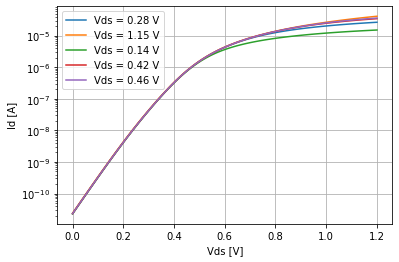

In [24]:
for v in np.random.choice(traces.Vds.unique(), 5, replace=False):
    trace = traces[(traces.Vds == v)]
    plt.plot(trace.Vgs, trace.id, label = f'Vds = {v} V')
plt.grid()
plt.yscale('log')
plt.xlabel('Vds [V]')
plt.ylabel('Id [A]')
plt.legend()

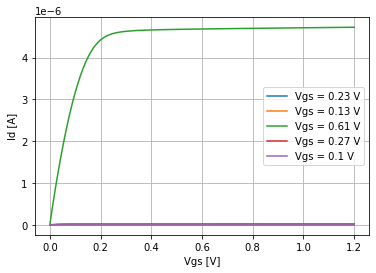

In [25]:
for v in np.random.choice(traces.Vgs.unique(), 5, replace=False):
    trace = traces[(traces.Vgs == v)]
    plt.plot(trace.Vds, trace.id, label = f'Vgs = {v} V')
plt.grid()
plt.xlabel('Vgs [V]')
plt.ylabel('Id [A]')
plt.legend()